In [1]:
import os
from PIL import Image
import numpy as np
import tensorrt as trt
import torch
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Image_size = 256
storage_dir = "./storage"
file_list = os.listdir(storage_dir+"/cache_"+str(Image_size))
print("Number of Images",len(file_list))
pics = [ storage_dir + "/cache_"+str(Image_size) + "/" +str(i) for i in file_list]

Number of Images 1050


In [3]:
np_pics = np.asarray(Image.open(pics[0]))
brain_tiles = np_pics.reshape(1,3,Image_size,Image_size)
for i in range(1049):
    img = np.asarray(Image.open(pics[i+1]))
    if (img.shape == (256, 256, 3)):
        brain_tiles = np.concatenate((brain_tiles,img.reshape(1,3,Image_size,Image_size)),axis=0)
    

In [4]:
brain_tiles = torch.from_numpy(brain_tiles).float()

In [5]:
brain_tiles = brain_tiles[:1024,:3,:,:]

In [6]:
brain_tiles.shape

torch.Size([1024, 3, 256, 256])

In [7]:
num_gpu = 2
chunk = brain_tiles.shape[0]//num_gpu

In [8]:
brain_batches = [brain_tiles[i:i+chunk,:,:,:] for i in range(0,brain_tiles.shape[0],chunk)]

In [9]:
len(brain_batches)

2

In [10]:
brain_batches[0].shape

torch.Size([512, 3, 256, 256])

In [11]:
brain_batches[1].shape

torch.Size([512, 3, 256, 256])

## Multi-GPU inference on TensorRT using ThreadPool

In [12]:
!ls | grep .plan

hovernet_256_4_best.plan
hovernet_256_4_fp16.plan
hovernet_256_8_best.plan
model.plan


In [13]:
from concurrent.futures import ThreadPoolExecutor
import TensorRT.InferMultiGPU as gpu
print(os.cpu_count())

6


In [14]:
model_name = "hovernet_256_4_best.plan"

In [15]:
infer_gpu = []
infer_gpu.append(gpu.GPU_infer(model_name,4,trt.float32,0))
infer_gpu.append(gpu.GPU_infer(model_name,4,trt.float32,1))

In [16]:
def iterate_batch(gpu,images):
    for i in range(0,images.shape[0],8):
        out = gpu.run_inf(images[i:i+8,:,:,:])
    gpu.clean()
    return out

In [ ]:
%%timeit
infer_gpu = []
infer_gpu.append(gpu.GPU_infer(model_name,4,trt.float32,0))
infer_gpu.append(gpu.GPU_infer(model_name,4,trt.float32,1))
with ThreadPoolExecutor(2) as executor:
    results = executor.map(iterate_batch,infer_gpu,brain_batches)

In [16]:
%%timeit
infer_gpu = []
infer_gpu.append(gpu.GPU_infer(model_name,8,trt.float32,0))
infer_gpu.append(gpu.GPU_infer(model_name,8,trt.float32,1))
with ThreadPoolExecutor(2) as executor:
    results = executor.map(iterate_batch,infer_gpu,brain_batches)

20.4 s ± 69.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
# for r in results:
#     print(r)

In [17]:
out = infer_gpu[0].run_inf(brain_batches[0][:4,:,:,:])

In [26]:
infer_gpu[0].h_output.dtype,type(infer_gpu[0].h_output)

(dtype('float32'), numpy.ndarray)

In [18]:
def visualize_channel(out,img_no = 0):
    fig , axs = plt.subplots(5,2,figsize=(12,15))
    k=0
    plt.axis('off')
    count = 0
    for i in range(5):
        for j in range(2):
            axs[i,j].xaxis.set_visible(False)
            axs[i,j].yaxis.set_visible(False)
            t = axs[i,j].imshow(out[img_no,k,:,:])
            plt.colorbar(t)
            axs[i,j].title.set_text( str(k) + " channel ")
            k+=1

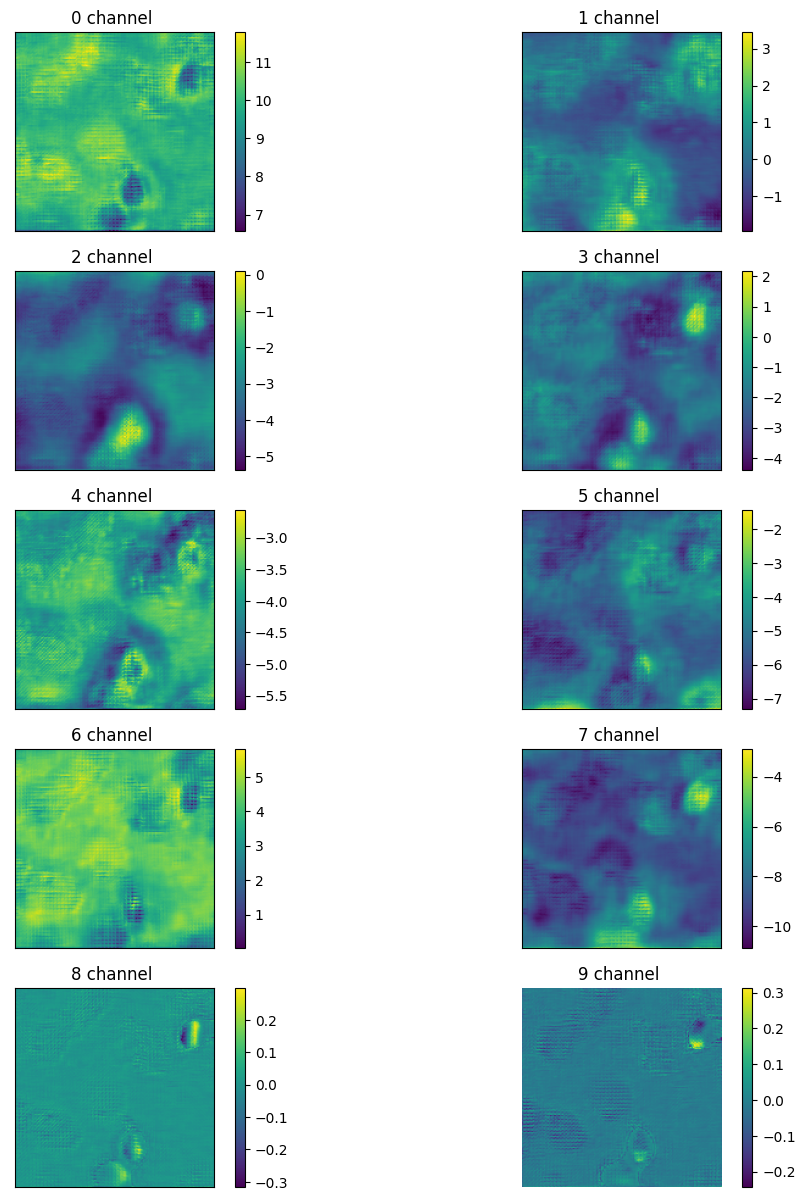

In [24]:
visualize_channel(out,3)

## Multi-GPU inference on Torch using ThreadPool

In [12]:
import os
from PIL import Image
import numpy as np
import tensorrt
import onnx
import gc
import models.hovernet.net_desc as net
import torch
import matplotlib.pyplot as plt
torch.set_grad_enabled(False)
Image_size = 256


In [13]:
from run_utils.utils import convert_pytorch_checkpoint

model_path = 'hovernet_fast_pannuke_type_tf2pytorch.tar'
hovernet = net.HoVerNet(nr_types = 6,mode='fast')
saved_state_dict = torch.load(model_path)["desc"]
saved_state_dict = convert_pytorch_checkpoint(saved_state_dict)

hovernet.load_state_dict(saved_state_dict, strict=True)
hovernet = torch.nn.parallel.DataParallel(hovernet,device_ids = [0,1])
hovernet = hovernet.to('cuda')
hovernet.eval()

DataParallel(
  (module): HoVerNet(
    (conv0): Sequential(
      (pad): TFSamepaddingLayer()
      (/): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (d0): ResidualBlock(
      (units): ModuleList(
        (0): Sequential(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (conv1/bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1/relu): ReLU(inplace=True)
          (conv2/pad): TFSamepaddingLayer()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (conv2/bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2/relu): ReLU(inplace=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): Sequential(
          (p

In [23]:
%%timeit
for i in range(0,brain_tiles.shape[0],4):
    out = hovernet.forward(brain_tiles[i:i+4,:,:,:])


1min 18s ± 96.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit
for i in range(0,brain_tiles.shape[0],8):
    out = hovernet.forward(brain_tiles[i:i+8,:,:,:])


1min 19s ± 174 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
